In [23]:
# Ferramentas matemáticas
import matplotlib.pyplot as plt
import numpy as np
import math
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

# Ferramentas para manipulação dos circuitos
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

# Multiplicação controlada por a mod 15
# U|y> = |ay mod15>
# Porta Controlled-U repetida "power" vezes
# Baseado em Monz et al: Realization of a scalableShor algorithm
def c_amod15(a, power):
    # gcd (a, 15) = 1
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    
    # Cria o circuito
    U = QuantumCircuit(4)
    
    # Constroi o circuito, depende do valor de a
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    
    # Encapsula o circuito como uma porta quântica            
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    controlled_U = U.control()
    return controlled_U


# QFT inversa para n qubits
def qft_dagger(n):
    # Cria o circuito
    qc = QuantumCircuit(n)
    
    # Troca os estados dos qubits
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    
    # Aplica as fases inversas
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


# Executar a parte quântica do algoritmo de Shor (a = 13, N = 15)
def qpe_amod15(a):
    # Número de qubits do contador
    n_count = 8
    
    # Cria o circuito para Shor com os qubits do contador
    # e 4 qubits para o registrador sobre o qual U será aplicado
    qc = QuantumCircuit(4+n_count, n_count)
    
    # Aplica as portas Hadamard nos qubits do contador 
    for q in range(n_count):
        qc.h(q)
    
    # Qubit ancilla no estado |1>
    qc.x(3+n_count)
    
    # Aplica as rotações U controladas
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
        
    # Aplica QFT dagger nos qubits do contador    
    qc.append(qft_dagger(n_count), range(n_count))
    
    # Adiciona as medições nos qubits do contador
    qc.measure(range(n_count), range(n_count))
    
    display(qc.draw(fold=-1))
    
    # Executa no simulador (memory=True permite visualizar uma lista de cada resultado sequencial)
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Medição do contador: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Fase correspondente: %f" % phase)
    return phase

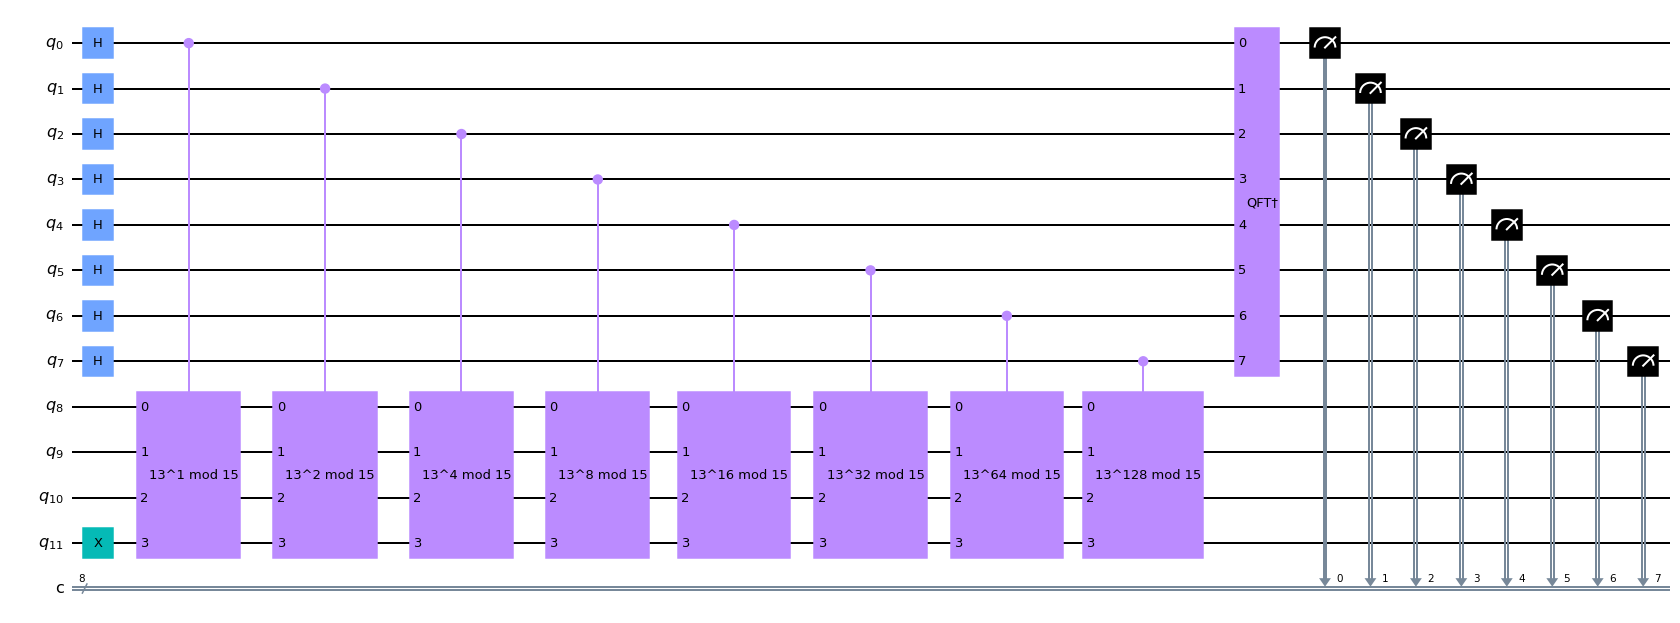

Medição do contador: 01000000
Fase correspondente: 0.250000
r = 4
Fatores =  [3, 5]


In [18]:
# Número para ser fatorado
N = 15

# Selecionar um número entre 1 e N-1
#np.random.seed(1)
#a = randint(2, 15)
#print("a = ", a)
a = 13 

# Verifica se o valor escolhido é um fator não trivial de N (gcd(a, N) != 1)
gcd(a, N)

# Phase = s/r
phase = qpe_amod15(a) 

# O denominador será um palpite para r
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print("r =", r)

# Tendo o palpite r, calculamos os possíveis fatores de N
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print("Fatores = ", guesses)


Tentativa 1:


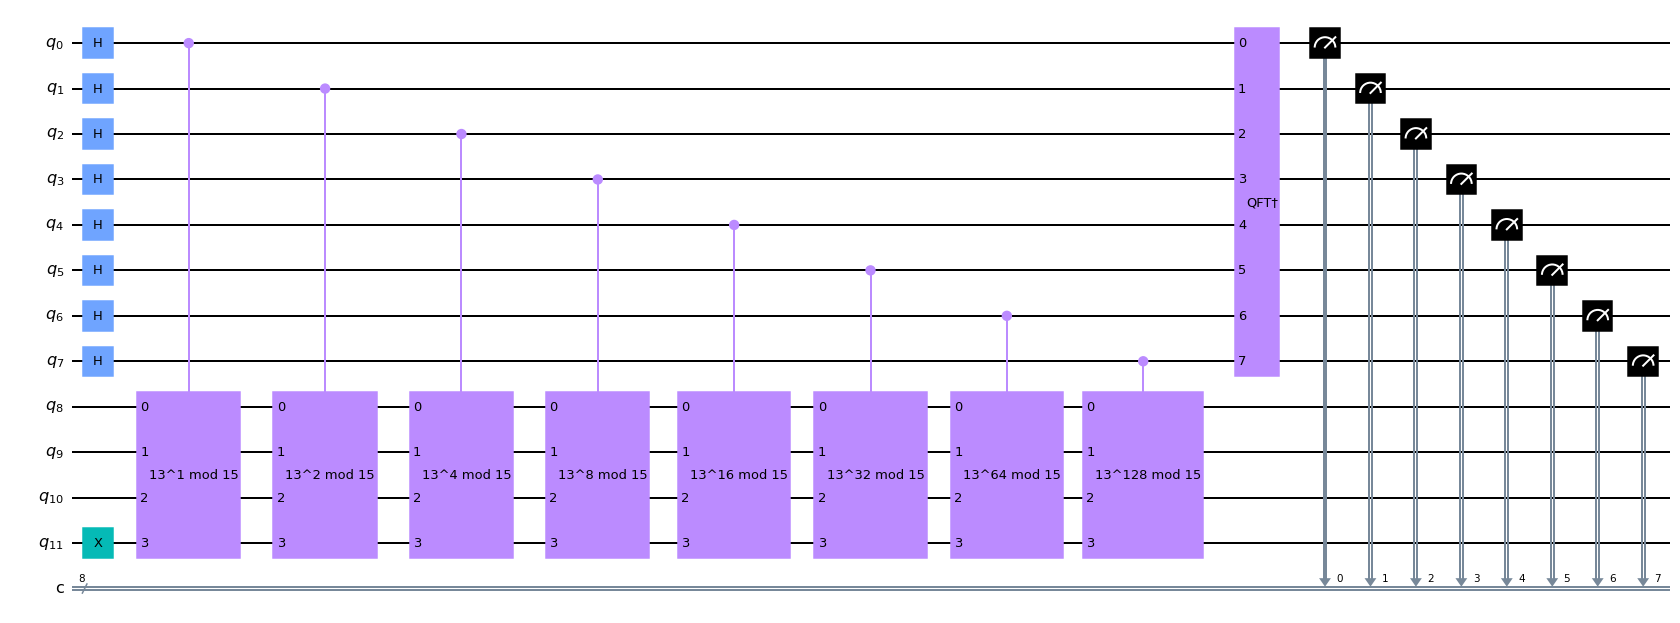

Medição do contador: 00000000
Fase correspondente: 0.000000
r = 1

Tentativa 2:


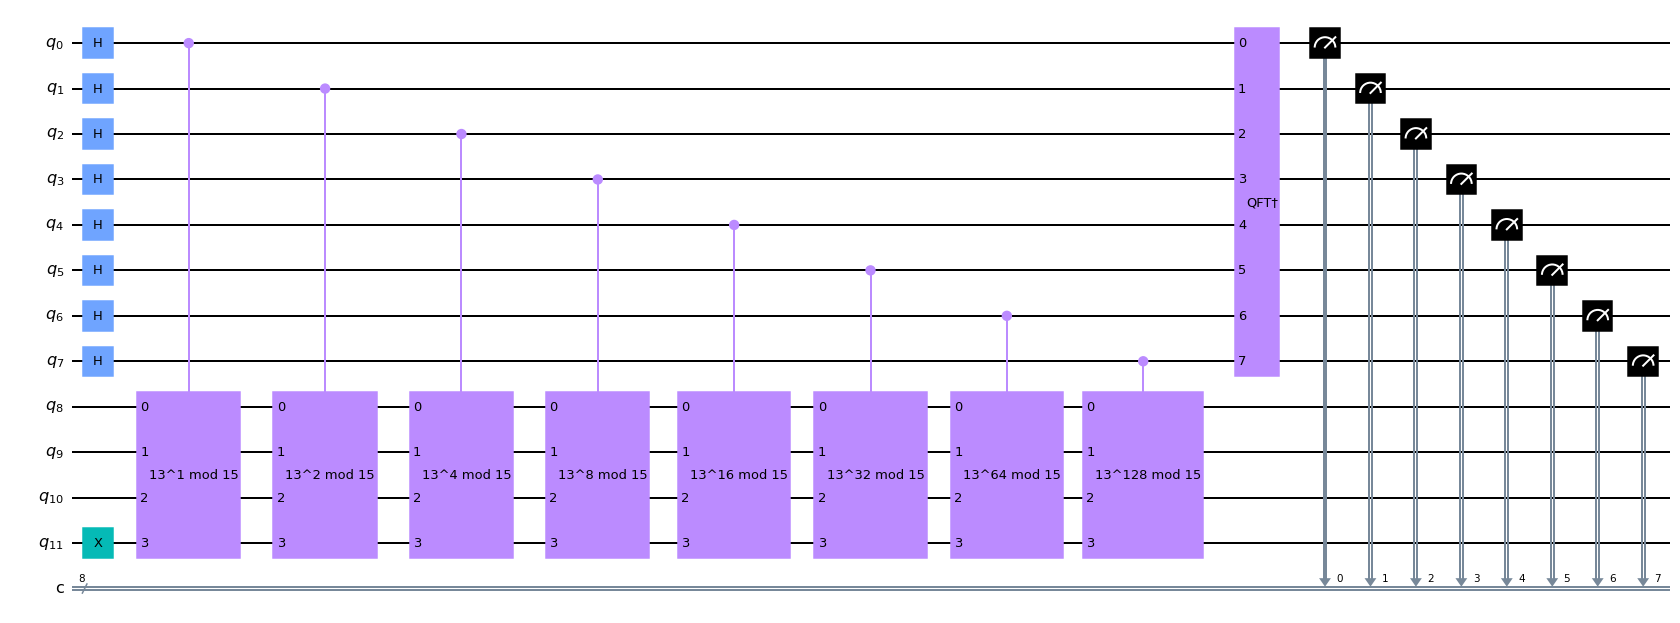

Medição do contador: 01000000
Fase correspondente: 0.250000
r = 4
Fatores: 3 and 5
*** Fator não trivial encontrado: 3 ***
*** Fator não trivial encontrado: 5 ***


In [22]:
# Como o algoritmo de Shor pode falhar, repetimos algumas vezes
# até encontrarmos pelo menos 1 fator de N. 
# Sendo N = x * y por exemplo, encontrando x basta que calculemos y = N / x

# base
a = 13

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nTentativa %i:" % attempt)
    
    # Phase = s/r
    phase = qpe_amod15(a) 
    
    # O denominador será um palpite para r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print("r = %i" % r)
    
    # Para os casos não triviais
    if phase != 0:
        # Os palpites para os fatores de N = 15 são gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Fatores: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            # Verifica se é um fator
            if guess not in [1,N] and (N % guess) == 0:
                print("*** Fator não trivial encontrado: %i ***" % guess)
                factor_found = True

In [ ]:
### Shor (Alto Nível) ###
# Ferramentas matemáticas
import numpy as np

# Ferramentas para manipulação dos circuitos
from qiskit.algorithms import Shor
from qiskit.utils import QuantumInstance
from qiskit import QuantumCircuit, Aer, execute

# Número para fatorar
N = 15

# Configuração para utilizar o simulador
backend = Aer.get_backend('aer_simulator')

# Configura uma instância do simulador
quantum_instance = QuantumInstance(backend)

# Configura o Algoritmo de Shor para fatorar N=15
shor = Shor(quantum_instance=quantum_instance)

# Executa o Algoritmo de Shor para a configuração desejada
result = shor.factor(N)
print(f"Os fatores de {N} calculados pelo algoritmo de Shor são {result.factors[0]}.")